In [1]:
from util.get_data import get_features_and_targets, get_normalized_features_and_targets
import pandas as pd
import matplotlib.pyplot as plt
import shap
import numpy as np

In [2]:
features, targets = get_features_and_targets()
features.head()

GENDER column transformed: [1 0]
EDUCATION_LEVEL column transformed: [2 1 3 4]
MARITAL_STATUS column transformed: [1 2 3]
CREDIT_LIMIT: 167 outliers capped.
AGE: 272 outliers capped.
SEPT_BILL: 2400 outliers capped.
AUG_BILL: 2395 outliers capped.
JULY_BILL: 2469 outliers capped.
JUNE_BILL: 2622 outliers capped.
MAY_BILL: 2725 outliers capped.
APRIL_BILL: 2693 outliers capped.
SEPT_PAYMENT: 2745 outliers capped.
AUG_PAYMENT: 2714 outliers capped.
JULY_PAYMENT: 2598 outliers capped.
JUNE_PAYMENT: 2994 outliers capped.
MAY_PAYMENT: 2945 outliers capped.
APRIL_PAYMENT: 2958 outliers capped.


,CREDIT_LIMIT,GENDER,EDUCATION_LEVEL,MARITAL_STATUS,AGE,SEPT_PAY_STATUS,AUG_PAY_STATUS,JULY_PAY_STATUS,JUNE_PAY_STATUS,MAY_PAY_STATUS,...,JULY_BILL,JUNE_BILL,MAY_BILL,APRIL_BILL,SEPT_PAYMENT,AUG_PAYMENT,JULY_PAYMENT,JUNE_PAYMENT,MAY_PAYMENT,APRIL_PAYMENT
1,20000,1,2,1,24.0,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0,689.0,0.0,0.0,0,0.0
2,120000,1,2,2,26.0,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0,1000.0,1000.0,1000.0,0,2000.0
3,90000,1,2,2,34.0,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518,1500.0,1000.0,1000.0,1000,5000.0
4,50000,1,2,1,37.0,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000,2019.0,1200.0,1100.0,1069,1000.0
5,50000,0,2,1,57.0,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000,11250.5,10000.0,9000.0,689,679.0


### K-means SMOTE to balance the data

In [3]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled =  pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

features_train, features_test, targets_train, targets_test = train_test_split(features_scaled, targets, test_size=0.3, random_state=0)

kmeans_smote = KMeansSMOTE(
    random_state=0,
    k_neighbors=5,
    cluster_balance_threshold=0.1,
    n_jobs=-1
)

features_train_resampled, targets_train_resampled = kmeans_smote.fit_resample(features_train, targets_train)

/Users/alejandromarchini/miniconda3/envs/credit_card_defaults_prediction/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## XGBoost and Feature Selection

### Recursive Feature Elimination using Logistic Regression

In [4]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform Recursive Feature Elimination (RFE)
rfe_logistic = RFE(estimator=logistic_model, n_features_to_select=1, step=1)
fit_logistic = rfe_logistic.fit(features_train_resampled, targets_train_resampled['DEFAULT'].values.ravel())

# Create a DataFrame for feature rankings
all_features_ranking = pd.DataFrame({
    'Feature': features.columns,
    'Ranking': fit_logistic.ranking_,
}).sort_values(by='Ranking')

# Display top-ranked features
print("Feature Ranking (Top 10):")
print(all_features_ranking.head(10))

Feature Ranking (Top 10):
            Feature  Ranking
5   SEPT_PAY_STATUS        1
7   JULY_PAY_STATUS        2
17     SEPT_PAYMENT        3
9    MAY_PAY_STATUS        4
11        SEPT_BILL        5
15         MAY_BILL        6
16       APRIL_BILL        7
21      MAY_PAYMENT        8
8   JUNE_PAY_STATUS        9
18      AUG_PAYMENT       10


### Baseline XGBoost with all features

In [5]:
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Helper function to run prediction and scores
def xgb_predict_and_score(model, x_test, y_test):
    pred = model.predict(x_test)
    score = accuracy_score(y_test, pred)
    print('Accuracy score: {}'.format(score))

    print("\nClassification Report:")
    print(classification_report(y_test, pred))

    print('ROC-AUC Score: {}'.format(roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])))

    plot_importance(model, importance_type='gain')
    plt.title('Feature Importance by Gain')
    plt.show()

Accuracy score: 0.8107777777777778

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      7060
           1       0.60      0.38      0.46      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000

ROC-AUC Score: 0.7530541237113402


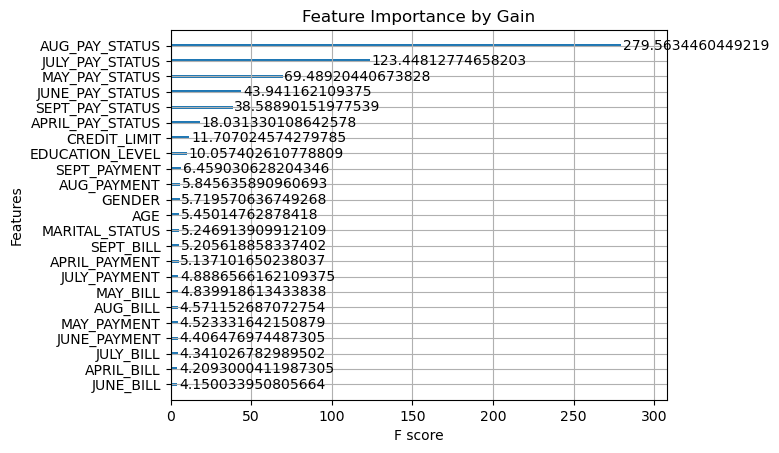

In [6]:
from xgboost import XGBClassifier

xgb_model_all_features = XGBClassifier(eval_metric='logloss')
xgb_model_all_features.fit(features_train_resampled, targets_train_resampled)

xgb_predict_and_score(xgb_model_all_features, features_test, targets_test)

### XGBoost with top 10 features by Gain

Accuracy score: 0.813

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.61      0.38      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.73      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7587560234806227


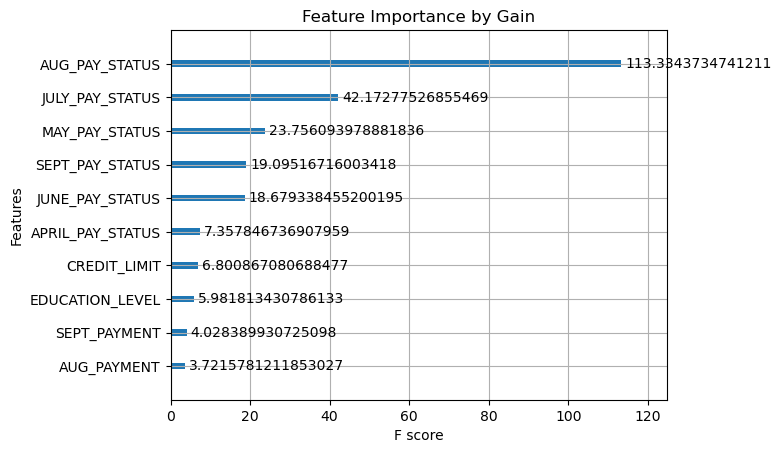

In [7]:
feature_importance = xgb_model_all_features.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Gain']).sort_values(by='Gain', ascending=False)
top_10_features = feature_importance_df.head(10).index.tolist()

xgb_model_top_10_features = XGBClassifier(eval_metric='logloss')
xgb_model_top_10_features.fit(features_train_resampled[top_10_features], targets_train_resampled)

xgb_predict_and_score(xgb_model_top_10_features, features_test[top_10_features], targets_test)

### XGBoost without demographic data

Accuracy score: 0.8124444444444444

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.60      0.38      0.47      1940

    accuracy                           0.81      9000
   macro avg       0.72      0.66      0.68      9000
weighted avg       0.79      0.81      0.80      9000

ROC-AUC Score: 0.7544101369702988


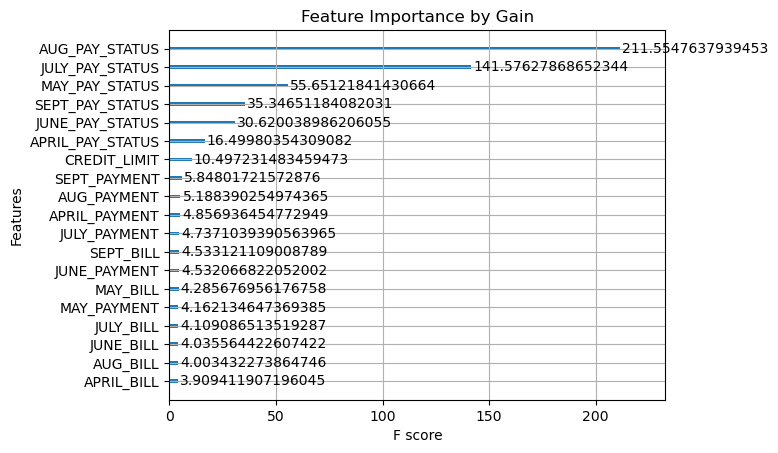

In [13]:
features_train_no_demographics = features_train_resampled.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)
features_test_no_demographics = features_test.drop(['GENDER', 'AGE', 'EDUCATION_LEVEL', 'MARITAL_STATUS'], axis=1)

xgb_model_no_demographics = XGBClassifier(eval_metric='logloss')
xgb_model_no_demographics.fit(features_train_no_demographics, targets_train_resampled)

xgb_predict_and_score(xgb_model_no_demographics, features_test_no_demographics, targets_test)

### Use only 3 most recent months in features

Accuracy score: 0.8165555555555556

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      7060
           1       0.62      0.40      0.48      1940

    accuracy                           0.82      9000
   macro avg       0.73      0.66      0.69      9000
weighted avg       0.80      0.82      0.80      9000

ROC-AUC Score: 0.7578848821588154


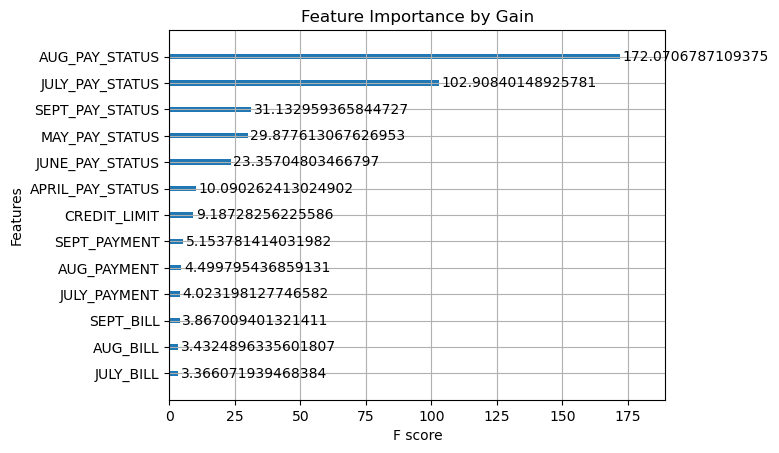

In [14]:
features_train_no_demo_most_recent = features_train_no_demographics.drop(['APRIL_BILL', 'APRIL_PAYMENT', 'MAY_BILL', 'MAY_PAYMENT', 'JUNE_BILL', 'JUNE_PAYMENT'], axis=1)
features_test_no_demo_most_recent = features_test_no_demographics.drop(['APRIL_BILL', 'APRIL_PAYMENT', 'MAY_BILL', 'MAY_PAYMENT', 'JUNE_BILL', 'JUNE_PAYMENT'], axis=1)

xgb_model_no_demo_most_recent = XGBClassifier(eval_metric='logloss')
xgb_model_no_demo_most_recent.fit(features_train_no_demo_most_recent, targets_train_resampled)

xgb_predict_and_score(xgb_model_no_demo_most_recent, features_test_no_demo_most_recent, targets_test)

## SHAP (SHapley Additive exPlanations)

### Feature Importance via SHAP Summary Plot

 99%|===================| 23761/24000 [00:59<00:00]        

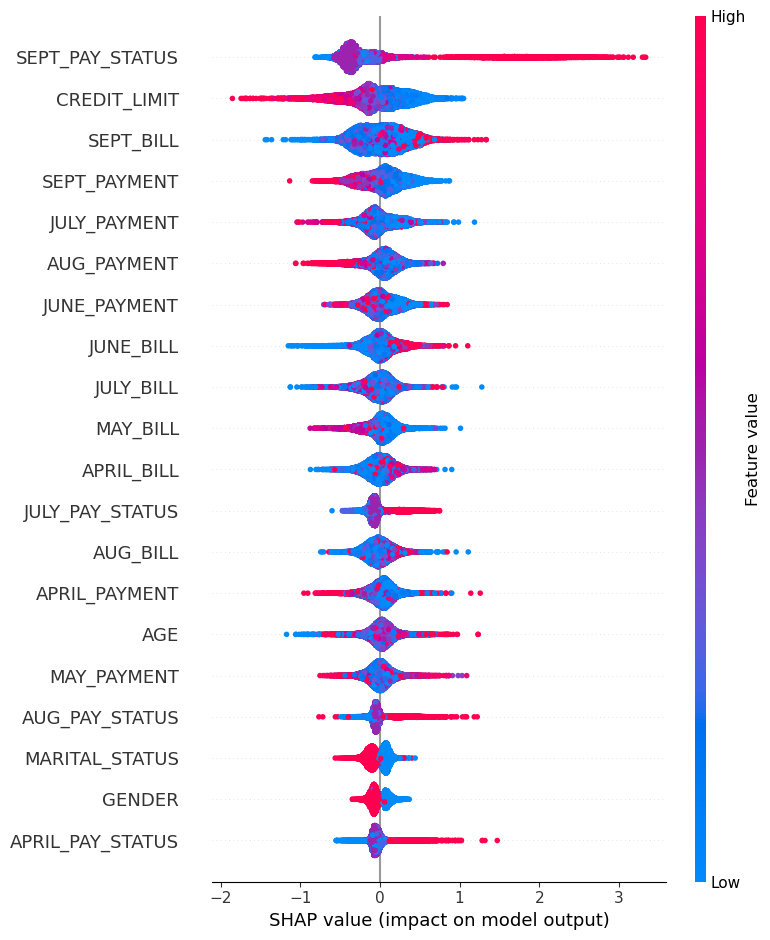

In [ ]:
#xgboost with all features 

# Create a SHAP explainer
explainer = shap.Explainer(xgb_model_all_features, features_train)

# Compute SHAP values
shap_values = explainer(features_train)

# SHAP summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, features_train)

 99%|===================| 23698/24000 [00:57<00:00]        

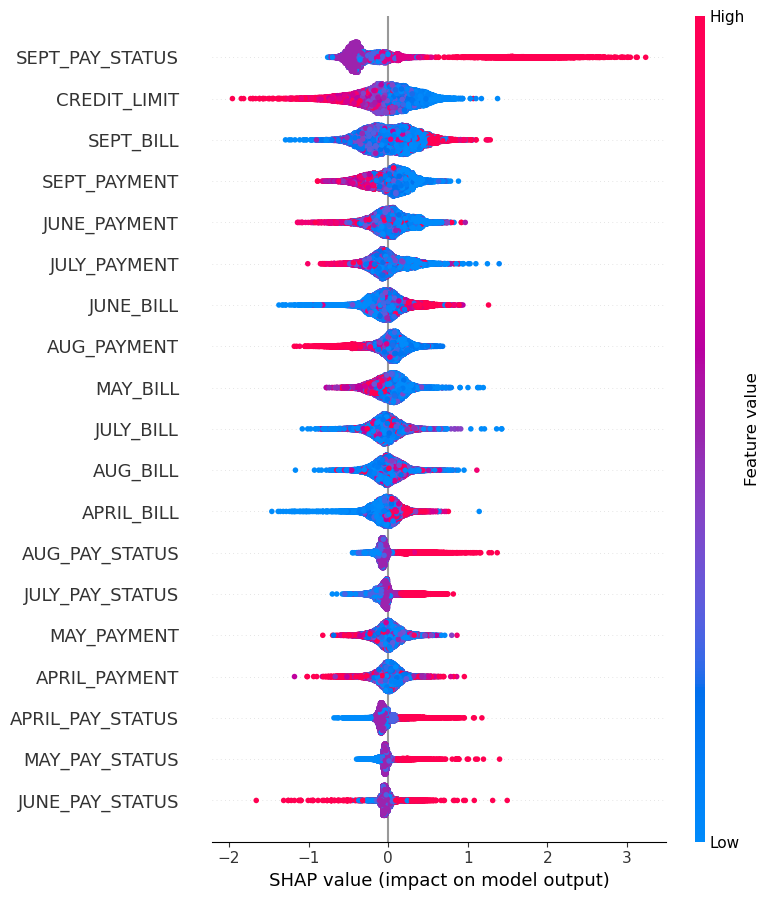

In [ ]:
#xgboost with no demographics 

# Create a SHAP explainer
explainer = shap.Explainer(xgb_model_no_demographics, features_train_no_demographics)

# Compute SHAP values
shap_values = explainer(features_train_no_demographics)

# SHAP summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, features_train_no_demographics)

### Feature rankings using SHAP - without demographics

In [ ]:
# Combine SHAP feature importance with RFE results
shap_importance = pd.DataFrame({
    'Feature': features_train_no_demographics.columns,
    'SHAP Importance': np.abs(shap_values.values).mean(axis=0),
}).sort_values(by='SHAP Importance', ascending=False)

# Merge RFE rankings
merged_importance = pd.merge(
    shap_importance,
    all_features_ranking,  # From RFE
    on='Feature'
)

# Sort the merged results by RFE rankings (ascending) and SHAP importance (descending)
merged_importance = merged_importance.sort_values(by=['SHAP Importance', 'Ranking'], ascending=[False, True])

# Filter the top 10 features based on their RFE rankings and SHAP importance
top_10_features = merged_importance.head(10)

# Display the top 10 robust features
print("Top Features from SHAP and RFE:")
print(top_10_features)

Top Features from SHAP and RFE:
           Feature  SHAP Importance  Ranking
0  SEPT_PAY_STATUS         0.457580        1
1     CREDIT_LIMIT         0.268738       23
2        SEPT_BILL         0.248417        4
3     SEPT_PAYMENT         0.189738        2
4     JUNE_PAYMENT         0.175266       21
5     JULY_PAYMENT         0.165233        8
6        JUNE_BILL         0.163745       11
7      AUG_PAYMENT         0.157727        6
8         MAY_BILL         0.140408       12
9        JULY_BILL         0.133670       18


### Feature Contribution for a Single Prediction

In [ ]:
# Aggregate SHAP values for a larger sample
sample_size = 500  # Use a larger sample size for better insights
subset_data = features_train.sample(n=sample_size, random_state=42)

# Compute SHAP values for the sample
shap_values_subset = explainer(subset_data, check_additivity=False)

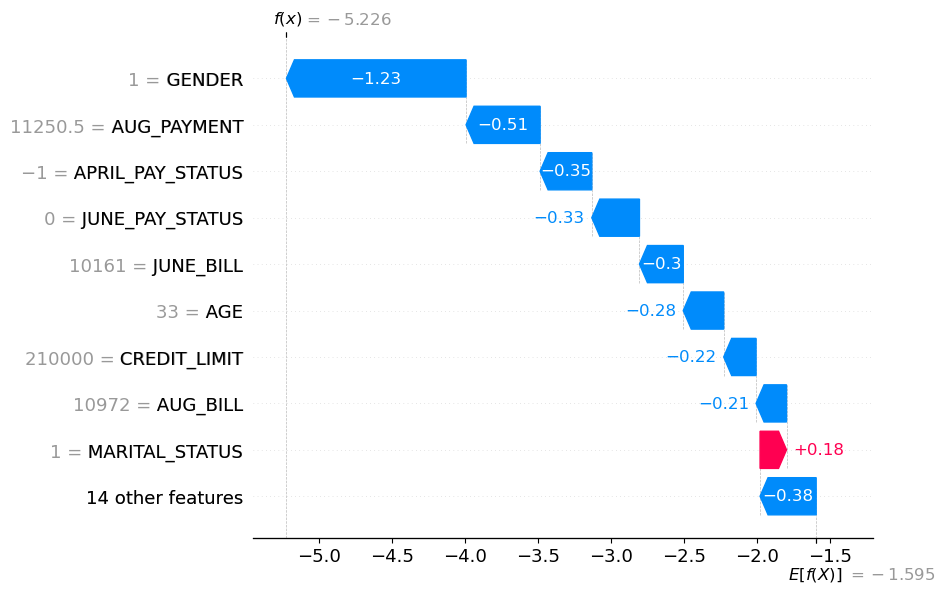

In [ ]:
# Filter for instances where SEPT_PAY_STATUS contributes positively
positive_contribution_idx = [
    i for i, shap_val in enumerate(shap_values_subset.values)
    if shap_val[subset_data.columns.get_loc('SEPT_PAY_STATUS')] > 0
]

# Plot waterfall for the first positive instance
if positive_contribution_idx:
    instance_data = subset_data.iloc[positive_contribution_idx[0]:positive_contribution_idx[0] + 1]
    shap_values_instance = explainer(instance_data, check_additivity=False)

    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_instance.values[0],
            base_values=shap_values_instance.base_values[0],
            data=instance_data.iloc[0],
            feature_names=subset_data.columns
        )
    )
else:
    print("No instances found where SEPT_PAY_STATUS contributes positively.")

### SHAP Interaction Values